In [94]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
%matplotlib inline

In [45]:
files = glob('data/faces94/**/*.jpg', recursive=True)
print("Image paths:", files)

Image paths: ['data/faces94/malestaff/tony/tony.17.jpg', 'data/faces94/malestaff/tony/tony.7.jpg', 'data/faces94/malestaff/tony/tony.6.jpg', 'data/faces94/malestaff/tony/tony.16.jpg', 'data/faces94/malestaff/tony/tony.14.jpg', 'data/faces94/malestaff/tony/tony.4.jpg', 'data/faces94/malestaff/tony/tony.5.jpg', 'data/faces94/malestaff/tony/tony.15.jpg', 'data/faces94/malestaff/tony/tony.11.jpg', 'data/faces94/malestaff/tony/tony.1.jpg', 'data/faces94/malestaff/tony/tony.10.jpg', 'data/faces94/malestaff/tony/tony.12.jpg', 'data/faces94/malestaff/tony/tony.2.jpg', 'data/faces94/malestaff/tony/tony.3.jpg', 'data/faces94/malestaff/tony/tony.13.jpg', 'data/faces94/malestaff/tony/tony.20.jpg', 'data/faces94/malestaff/tony/tony.18.jpg', 'data/faces94/malestaff/tony/tony.8.jpg', 'data/faces94/malestaff/tony/tony.9.jpg', 'data/faces94/malestaff/tony/tony.19.jpg', 'data/faces94/malestaff/anonym/anonym.20.jpg', 'data/faces94/malestaff/anonym/anonym.8.jpg', 'data/faces94/malestaff/anonym/anonym.19.j

In [48]:
def load_data(files):
    images = []
    for file in files:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        images.append(img)
    return images

In [49]:
data = load_data(files)
data_arr = np.array(data)
print("Data shape:", data_arr.shape)

Data shape: (3059, 200, 180)


## Average Face

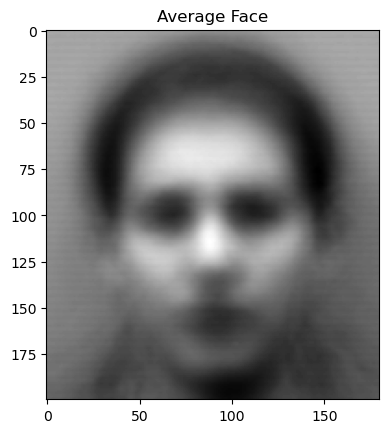

In [70]:
average_face = np.mean(data_arr, axis=0).astype(np.uint8)
plt.imshow(average_face, cmap='gray')
plt.title("Average Face")
plt.show()

In [51]:
flatten_data = data_arr.reshape(data_arr.shape[0], -1)
print("Flatten data shape:", flatten_data.shape)

Flatten data shape: (3059, 36000)


## 5 Eigenfaces

In [52]:
def pca(X, n_components):
    mean = np.mean(X, axis=0)
    n = X.shape[0]
    X = X - mean
    feature_corr = X @ X.T
    eigvals, eigvecs = np.linalg.eig(feature_corr)
    top_eigvecs = eigvecs[:, :n_components]
    top_eigenvalues = eigvals[:n_components]
    normalization = 1 / np.sqrt(n * top_eigenvalues)
    print("Top eigenvalues:", top_eigenvalues.shape)
    print("Top eigenvectors:", top_eigvecs.shape)
    print("Normalization shape:", normalization.shape)
    U = X.T @ top_eigvecs @ np.diag(normalization) 
    return U
    

In [53]:
eigenfaces = pca(flatten_data, 5)

Top eigenvalues: (5,)
Top eigenvectors: (3059, 5)
Normalization shape: (5,)


In [57]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

In [60]:
def plot_image(image, title, ax):
    normalized_image = min_max_normalize(image)
    ax.imshow(normalized_image, cmap='gray')
    ax.set_title(title)

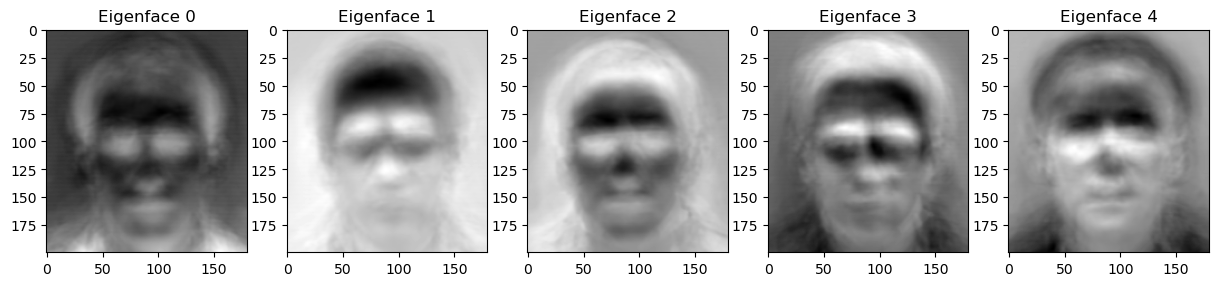

In [150]:
fig, axes = plt.subplots(1, 5, figsize=(15, 8))
for i in range(5):
    ax = axes[i]
    eigenface = eigenfaces[:, i].reshape(average_face.shape)
    plot_image(eigenface, f"Eigenface {i}", ax)
plt.show()

## Reconstruct an Image With Different PCA Dimensions

In [63]:
def pca_encode(image, U):
    image = image.flatten()
    encoded = U.T @ image
    return encoded

def pca_decode(encoded, U, shape):
    decoded = U @ encoded
    decoded = decoded.reshape(shape)
    
    return decoded

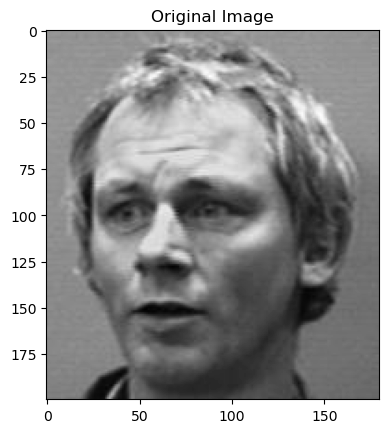

In [65]:
plt.imshow(data[0], cmap='gray')
plt.title("Original Image")
plt.show()

In [66]:
def multiple_iter_pca(X, n_components_list):
    mean = np.mean(X, axis=0)
    n = X.shape[0]
    X = X - mean
    feature_corr = X @ X.T
    eigvals, eigvecs = np.linalg.eig(feature_corr)
    principal_components_dict = {}
    max_n_components = max(n_components_list)
    top_eigvecs = eigvecs[:, :max_n_components]
    top_eigenvalues = eigvals[:max_n_components]
    normalization = 1 / np.sqrt(n * top_eigenvalues)
    U = normalization * (X.T @ top_eigvecs)
    for n_components in n_components_list:
        principal_components_dict[n_components] = U[:, :n_components]
    return principal_components_dict

In [67]:
principal_components_dicts = multiple_iter_pca(flatten_data, [2, 5, 10, 20, 50, 100, 300])

In [68]:
import pickle

with open('principal_components_dicts_gray.pkl', 'wb') as f:
    pickle.dump(principal_components_dicts, f)

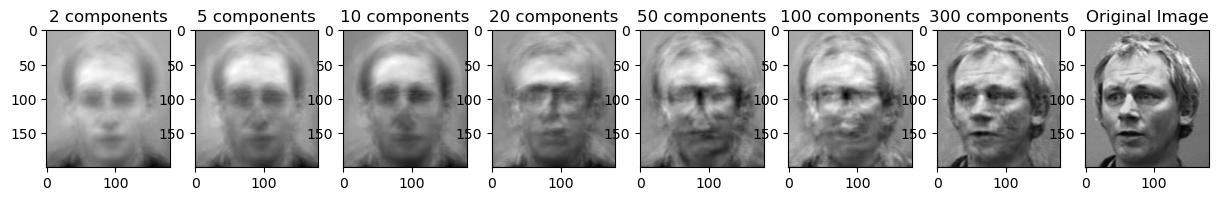

In [69]:
def plot_image_reconstruction(img, principal_components_dicts):
    fig, axes = plt.subplots(1, 8, figsize=(15, 8))
    i = 0
    for key, value in principal_components_dicts.items():
        ax = axes[i]
        encoded = pca_encode(img, value)
        decoded = pca_decode(encoded, value, img.shape)
        plot_image(decoded, f"{key} components", ax)
        i += 1
    axes[-1].imshow(img, cmap='gray')
    axes[-1].set_title("Original Image")
plot_image_reconstruction(data[0], principal_components_dicts)

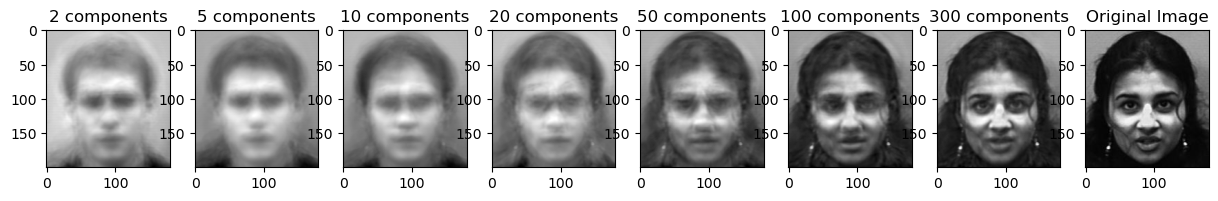

In [144]:
plot_image_reconstruction(data[3000], principal_components_dicts)

In [227]:
def reconstruction_score(original, reconstructed):
    cost = np.sum(np.abs(original.astype(np.int64) - reconstructed.astype(np.int64))) / (original.shape[0] * original.shape[1] * 255)
    return cost

In [213]:
def plot_reconstruction_cost(original):
    fig, axes = plt.subplots(3, 7, figsize=(15, 8))
    i = 0
    for key, value in principal_components_dicts.items():
        reconstructed = (min_max_normalize(pca_decode(pca_encode(original, value), value, original.shape)) * 255).astype(np.uint8)
        diff = np.abs(original.astype(np.int64) - reconstructed.astype(np.int64))
        axes[0, i].imshow(diff, cmap='gray')
        axes[0, i].set_title(f"{key} components")
        axes[1, i].imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
        axes[2, i].imshow(original, cmap='gray', vmin=0, vmax=255)
        i += 1
    plt.show()

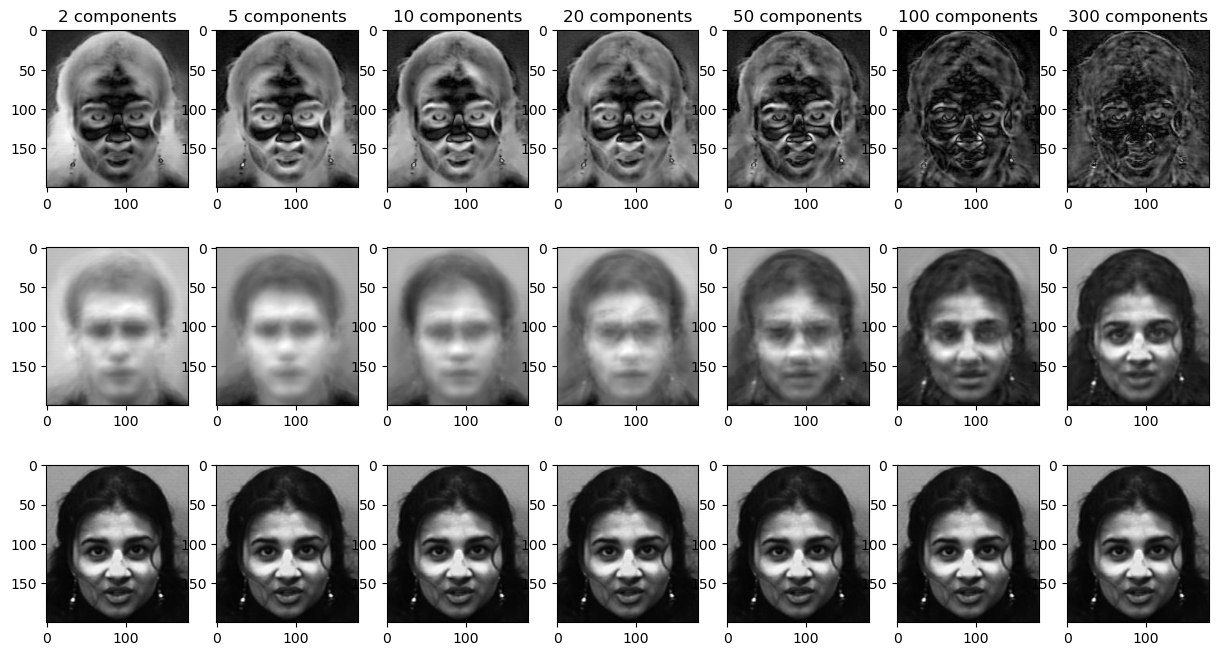

In [214]:
original = data[3000]
plot_reconstruction_cost(original)

In [222]:
scores = []
for key, value in principal_components_dicts.items():
    reconstructed = reconstructed = (min_max_normalize(pca_decode(pca_encode(original, value), value, original.shape)) * 255).astype(np.uint8)
    scores.append(reconstruction_score(original, reconstructed))
    print(f"Reconstruction score for {key} components: {scores[-1]}")

cost:  0.38579117647058825
Reconstruction score for 2 components: 0.38579117647058825
cost:  0.2808674291938998
Reconstruction score for 5 components: 0.2808674291938998
cost:  0.25479270152505445
Reconstruction score for 10 components: 0.25479270152505445
cost:  0.2536409586056645
Reconstruction score for 20 components: 0.2536409586056645
cost:  0.15030468409586056
Reconstruction score for 50 components: 0.15030468409586056
cost:  0.07433910675381264
Reconstruction score for 100 components: 0.07433910675381264
cost:  0.05802440087145969
Reconstruction score for 300 components: 0.05802440087145969


In [223]:
def plot_cost_vs_components(costs, components):
    plt.plot(components, costs)
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Cost")
    plt.title("Reconstruction Cost vs Number of Components")
    plt.show()

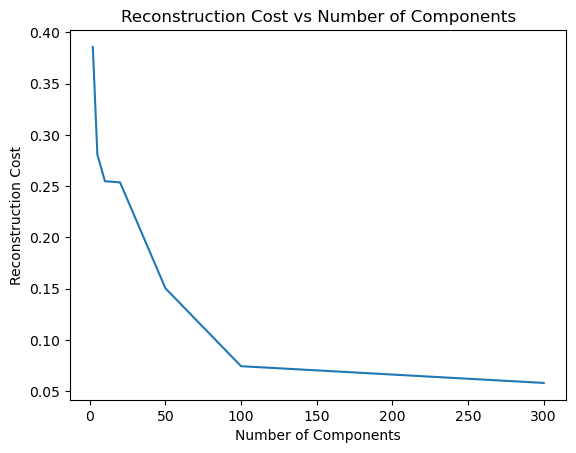

In [224]:
plot_cost_vs_components(scores, list(principal_components_dicts.keys()))

In [228]:
validation_indices = np.random.choice(data_arr.shape[0], 10, replace=False)
validation_data = data_arr[validation_indices]
principal_components_costs = {}
for img in validation_data:
    for key, value in principal_components_dicts.items():
        reconstructed = (min_max_normalize(pca_decode(pca_encode(img, value), value, img.shape)) * 255).astype(np.uint8)
        cost = reconstruction_score(img, reconstructed)
        if key not in principal_components_costs:
            principal_components_costs[key] = []
        principal_components_costs[key].append(cost)
for key in principal_components_costs:
    principal_components_costs[key] = np.mean(principal_components_costs[key])
principal_components_costs

{2: 0.2894426361655773,
 5: 0.2128325708061002,
 10: 0.19315493464052289,
 20: 0.18622105664488017,
 50: 0.1165201633986928,
 100: 0.09748832244008715,
 300: 0.05854575163398692}

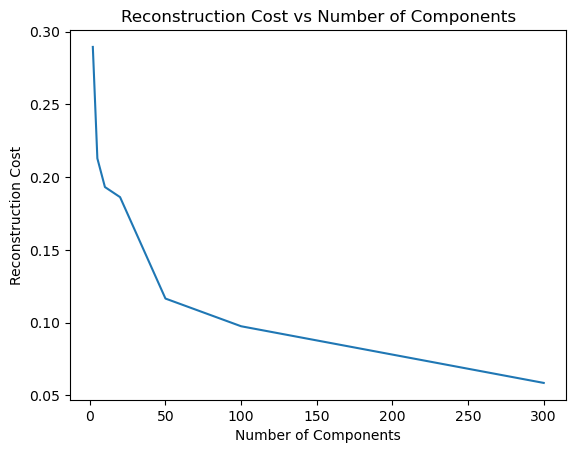

In [229]:
plot_cost_vs_components(list(principal_components_costs.values()), list(principal_components_costs.keys()))

In [243]:
def predict(cost, threshold, image_flag):
    if cost < threshold and image_flag:
        return "tp"
    elif cost < threshold and not image_flag:
        return "fp"
    elif cost > threshold and image_flag:
        return "fn"
    else:
        return "tn"

In [233]:
test_data = load_data(glob('data/test_images_pair/**/*.jpg'))
test_data_arr = np.array(test_data)
print("Test data shape:", test_data_arr.shape)

Test data shape: (20, 200, 180)


In [245]:
predictions = []
n_components = 100
U = principal_components_dicts[n_components]

for img in test_data:
    reconstructed = (min_max_normalize(pca_decode(pca_encode(img, U), U, img.shape)) * 255).astype(np.uint8)
    cost = reconstruction_score(img, reconstructed)
    image_flag = True
    prediction = predict(cost, 0.1, image_flag)
    predictions.append(prediction)
    negative_samples = [image for image in test_data if image is not img]
    for negative_sample in negative_samples:
        cost = reconstruction_score(negative_sample, reconstructed)
        image_flag = False
        prediction = predict(cost, 0.1, image_flag)
        predictions.append(prediction)
predictions

['tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'fp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'fp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'fn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'fp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',

In [253]:
def build_negative_sample(index, data):
    if index % 2 == 0:
        negative_samples = [image for image in data if image is not data[index] and image is not data[index + 1]]
    else:
        negative_samples = [image for image in data if image is not data[index] and image is not data[index - 1]]
    return negative_samples

In [265]:
predictions = []
n_components = 100
U = principal_components_dicts[n_components]

for i in range(test_data_arr.shape[0]):
    img = test_data_arr[i]
    reconstructed = (min_max_normalize(pca_decode(pca_encode(img, U), U, img.shape)) * 255).astype(np.uint8)
    cost = reconstruction_score(img, reconstructed)
    image_flag = True
    prediction = predict(cost, 0.1, image_flag)
    predictions.append(prediction)
    negative_samples = build_negative_sample(i, test_data)
    for negative_sample in negative_samples:
        cost = reconstruction_score(negative_sample, reconstructed)
        image_flag = False
        prediction = predict(cost, 0.1, image_flag)
        predictions.append(prediction)
predictions

['tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'fn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tp',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',
 'tn',

In [266]:
fp_count = predictions.count("fp")
fn_count = predictions.count("fn")
tp_count = predictions.count("tp")
tn_count = predictions.count("tn")
precision = tp_count / (tp_count + fp_count)
precision

1.0

In [267]:
recall = tp_count / (tp_count + fn_count)
recall

0.8

In [268]:
accuracy = (tp_count + tn_count) / len(predictions)
accuracy

0.9894736842105263